In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple

from statsmodels.tsa.stattools import adfuller

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

import torch
import torch.nn as nn
import torch.nn.functional as F

# depending on your OS
# --------------------
from tqdm import trange,tqdm
# from tqdm.notebook import trange,tqdm # works for Linux
# --------------------

from IPython.display import clear_output

%matplotlib inline

In [2]:
%pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [3]:
import catboost

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

In [5]:
MDATA_PATH = '/content/drive/MyDrive/mdata'

DEVICE = 'cpu' # you may try 'cuda' if your machine supports NVIDIA

---

In [6]:
def get_dates():
    return sorted(os.listdir(MDATA_PATH))

def get_tickers():
    dates = get_dates()
    tickers = []
    for date in dates:
        tickers += os.listdir(os.path.join(MDATA_PATH,date))
    return np.unique(tickers)

def get_market_data(ticker):
    agg_mmf_data_raw = []
    for date in get_dates():
        if not os.path.exists(os.path.join(MDATA_PATH,date,ticker)):
            continue
        df = pd.read_csv(
            os.path.join(MDATA_PATH,date,ticker),
            compression='gzip',
            dtype={'bar_time':float,'TIMESTAMP':float},
            index_col=0,
            parse_dates=[2,3],
            date_parser=pd.to_datetime,
        ).sort_values(by=['VOLUME','bar_count']).groupby('bar_time',as_index=False).last()
        agg_mmf_data_raw.append(df)
    agg_mmf_data_raw = pd.concat(agg_mmf_data_raw).set_index('bar_time').sort_index()
    
    agg_price_grid_raw = agg_mmf_data_raw.filter(like='PRICE_GRID')
    agg_vol_grid_raw = agg_mmf_data_raw.filter(like='VOL_GRID')

    agg_mmf_data_raw = agg_mmf_data_raw[ agg_mmf_data_raw.columns[(
        ~agg_mmf_data_raw.columns.str.startswith('EXEC')
        &
        ~agg_mmf_data_raw.columns.str.startswith('PRICE_GRID')
        &
        ~agg_mmf_data_raw.columns.str.startswith('VOL_GRID')
    )]]
    agg_mmf_data_raw.drop([
        'TIMESTAMP','ZERO_SPREAD_ON_TRADE','EMPTY_LOB_SIDE_AFTER_UPDATE','NEGATIVE_SPREAD_AFTER_UPDATE',
        'ZERO_SPREAD_AFTER_UPDATE','EMPTY_LOB_SIDE_ON_TRADE','NEGATIVE_SPREAD_ON_TRADE','bar_count','WEEKDAY'
    ],inplace=True,axis=1)
    
    return agg_mmf_data_raw,agg_price_grid_raw

def get_adf_p_value(dtest):
    dftest = adfuller(dtest, maxlag=10)
    p_value = dftest[1]
    return p_value

def generate_features(mmf_data_raw,price_grid_raw,preserve_cols=['DVOL']):
    dset = (mmf_data_raw.BEST_ASK/2 + mmf_data_raw.BEST_BID/2).to_frame('MID_PRICE') 

    dset['TG_Y'] =  (mmf_data_raw['VWAP'].shift(-2) - mmf_data_raw['VWAP'].shift(-1)) / mmf_data_raw['VWAP'].shift(-1)
    
    dset['R1_X'] =  (dset['MID_PRICE'] - dset['MID_PRICE'].shift(1)) * 100
    dset['R2_X'] =  (dset['MID_PRICE'] - dset['MID_PRICE'].shift(2) ) * 100

    dset['R1V_X'] =  (mmf_data_raw['VWAP'] - mmf_data_raw['VWAP'].shift(1)) * 100
    dset['R2V_X'] =  (mmf_data_raw['VWAP'] - mmf_data_raw['VWAP'].shift(2) ) * 100
    
    dset['RVW_ema_X'] =  mmf_data_raw['VWAP'] - mmf_data_raw['VWAP'].ewm(halflife=8).mean()
    dset['RVW_ema2_X'] =  mmf_data_raw['VWAP'].ewm(halflife=8).mean() - mmf_data_raw['VWAP'].ewm(halflife=16).mean()
    dset['RVW_ema3_X'] =  mmf_data_raw['VWAP'].ewm(halflife=16).mean() - mmf_data_raw['VWAP'].ewm(halflife=32).mean()
    dset['RVW_ema4_X'] =  mmf_data_raw['VWAP'].ewm(halflife=32).mean() - mmf_data_raw['VWAP'].ewm(halflife=64).mean()
    
    for col in preserve_cols:
        dset[f"{col}_X"] = mmf_data_raw[col]
    
    dset['DVOL_EMA3_X'] = dset['DVOL_X'].ewm(halflife=3).mean()
    dset['DVOL_EMA10_X'] = dset['DVOL_X'].ewm(halflife=10).mean()

    dset['BTC_BID_VOL'] = price_grid_raw[['PRICE_GRID_0.991026', 'PRICE_GRID_0.993590', 'PRICE_GRID_0.996154', 'PRICE_GRID_0.998718']].sum(axis=1).abs()
    dset['BTC_ASK_VOL'] = price_grid_raw[['PRICE_GRID_1.001282','PRICE_GRID_1.003846', 'PRICE_GRID_1.006410', 'PRICE_GRID_1.008974']].sum(axis=1).abs()
    dset['OIR_X'] = (dset['BTC_BID_VOL'] - dset['BTC_ASK_VOL']) / (dset['BTC_BID_VOL'] + dset['BTC_ASK_VOL'])
    
    X, y = dset.filter(like='_X'), dset.filter(like='_Y')
    return X,y


---

In [7]:
tickers = get_tickers()
print (tickers)

['Z.ADA' 'Z.BNB' 'Z.BTC' 'Z.DOGE' 'Z.DOT' 'Z.ETC' 'Z.ETH' 'Z.FIL' 'Z.LINK'
 'Z.LTC' 'Z.MATIC' 'Z.THETA' 'Z.UNI' 'Z.XRP']


In [8]:
# SELECT ONE ON YOUR PREFERENCE
ticker = 'Z.DOGE'

In [9]:
agg_mmf_data_raw,agg_price_grid_raw = get_market_data(ticker)

# getting rid of the integrated time series, use with caution
adf_test_p_value = agg_mmf_data_raw.aggregate(get_adf_p_value,axis=0)
preserve_cols = adf_test_p_value.loc[lambda x: x<1e-4].index

X_mmf,y_regr = generate_features(agg_mmf_data_raw,agg_price_grid_raw,preserve_cols=preserve_cols)
y_regr = y_regr * 100
nna_indices = X_mmf.notnull().min(axis=1) & agg_price_grid_raw.notnull().min(axis=1) & y_regr.notnull().min(axis=1)
agg_mmf_data_raw,agg_price_grid_raw,X_mmf,y_regr = agg_mmf_data_raw[nna_indices],agg_price_grid_raw[nna_indices],X_mmf[nna_indices],y_regr[nna_indices]

---

Splitting train / test , 70/30 \
Transfrom train and test features to quantiles

In [10]:
n_features = X_mmf.shape[1]
X_train,X_test, y_train,y_test = train_test_split(X_mmf,y_regr,test_size=0.3,shuffle=False)

qt = QuantileTransformer()
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

---

# CatBoost regressor

We will use it as benchmark, i.e. compare our LSTM result with catboost result

In [11]:
cb_regressor = catboost.CatBoostRegressor(depth=8)
cb_regressor.fit(X_train,y_train,silent=True)

y_train_pred_cb = cb_regressor.predict(X_train)
y_test_pred_cb = cb_regressor.predict(X_test)

cb_mse_error_train = metrics.mean_squared_error(y_train,y_train_pred_cb)
cb_mse_error_test  = metrics.mean_squared_error(y_test,y_test_pred_cb)

---

# Define dataset

MMF stands for Market Microstructure Features

In [12]:
# good idea to store all hyperparameters and experiment settings in a dedicated dictionary
# this way you can store the dictionary in wandb and compare all the settings between several experiments

mmf_params = dict(
    hid_size1 = 128,
    hid_size2 = 16,
    batch_size = 128,
    learning_rate = 1e-04,
    episode_len = 128,
    lstm_warm_up = 32
)

In [13]:
# to properly pass our data to LSTM, we need to define how we will iterate through the dataset
# to do that, we define a custom class derived from torch.utils.data.Dataset, and overwrite its __len__ and __getitem__ methods
# these methods allow the dataset to be iterated in a way we need

MMF_Episode = namedtuple('MMF_Episode', ['features', 'targets'])

class MMF_Set(torch.utils.data.Dataset):
    def __init__(self,X,y,episode_len):
        super().__init__()
        
        self.feature_t =  torch.tensor(X, dtype=torch.float32, device=DEVICE) # transform X to tensor of type float32 and convert it to DEVICE
        self.target_t  =  torch.tensor(y, dtype=torch.float32, device=DEVICE) # transform y to tensor of type float32 and convert it to DEVICE
        self.n_ticks, self.n_features = X.shape
        self.episode_len = episode_len

    def __len__(self):
        return self.n_ticks-self.episode_len+1
    
    # get i-th "rolling window"
    def __getitem__(self,i):
        return MMF_Episode(
            features = self.feature_t[i:i+self.episode_len] , # get the slice of feature_t tensor from i to i+episode_len
            targets =  self.target_t[i:i+self.episode_len] , # get the slice of target_t tensor from i to i+episode_len
        )

In [14]:
mmf_train_feature_set = MMF_Set(X_train.copy(),pd.DataFrame(y_train).values,episode_len=mmf_params['episode_len'])

For debugging purposes

In [15]:
# torch format of the dataset
# splitting to batches
mmf_train_feature_set_t = torch.utils.data.DataLoader(mmf_train_feature_set,batch_size=20,shuffle=True,num_workers=0)

mmf_item = next(iter(mmf_train_feature_set_t))

# make sure this output is [n_batches, n_episodes, n_features], [n_batches, n_episodes, 1]
mmf_item.features.shape, mmf_item.targets.shape

(torch.Size([20, 128, 33]), torch.Size([20, 128, 1]))

---

# Transforming data to torch-compatible format

we have to do this, because any nn.Module accepts only torch tensors as input

In [16]:
X_train_t = torch.tensor(X_train, dtype=torch.float32) # transform X_train to tensor of type float32
X_test_t  = torch.tensor(X_test, dtype=torch.float32) # transform X_test to tensor of type float32

y_train_t = torch.tensor(y_train.values, dtype=torch.float32) # transform y_train of size [n] to tensor of type float32 and shape [n,1]
y_test_t  = torch.tensor(y_test.values, dtype=torch.float32) # transform y_test of size [n] to tensor of type float32 and shape [n,1]

In [17]:
X_train_t.shape, X_test_t.shape

(torch.Size([232382, 33]), torch.Size([99593, 33]))

---

# Network definition

In [18]:
class MMF_LSTM(nn.Module):
    def __init__(self,input_size,hid_size1,hid_size2):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hid_size1) # initialize a nn.LSTM object dealing with batches of input_size = input_size and hidden_size = hid_size1
        
        # the following part is in general of your own freedom of choice
        # instead of what we propose, you may use just one linear transformation hid_size1 -> 1
        
        self.hid_to_hll = nn.Linear(in_features=hid_size1, out_features=hid_size2) # initialize linear transformation with #{input features} = hid_size1 and #{output_features} = hid_size2
        self.hll_to_out = nn.Linear(in_features=hid_size2, out_features=1) # initialize linear transformation with #{input features} = hid_size2 and #{output features} = 1
    
    def forward(self,x):
        # the forward pass has to be as follows:
        # lstm -> first linear layer -> ReLU -> second linear layer
        
        x, _ = self.lstm(x) # get result of lstm network defined in constructor
        x = self.hid_to_hll(x)
        x = F.relu(x)
        output = self.hll_to_out(x)

        return output 

---

# Main train loop

In [19]:
mmf_lstm_model = MMF_LSTM(input_size=n_features, hid_size1=mmf_params['hid_size1'], hid_size2=mmf_params['hid_size2']) # define LSTM object of our custom class with input size = n_features (variable from cell [7]) and hidden sizes from mmf_params
mmf_loss_fn = nn.MSELoss() # define a criterion - mean squared error
mmf_optimizer = torch.optim.Adam(params=mmf_lstm_model.parameters(), lr=mmf_params['learning_rate']) # define Adam optimizer receiving mmf_lst_model parameters and learning rate defined in mmf_params

mmf_activation_fn = torch.tanh # define activation function - hyperbolic tangent
mmf_warm_up = mmf_params['lstm_warm_up'] # define a warm-up window to start training the model, from mmf_params

In [20]:
# lists to store performance metrics of the learning

train_loss_history = []
max_gradient_history = []
mse_train_history = []
mse_test_history = []

In [21]:
mmf_train_feature_set

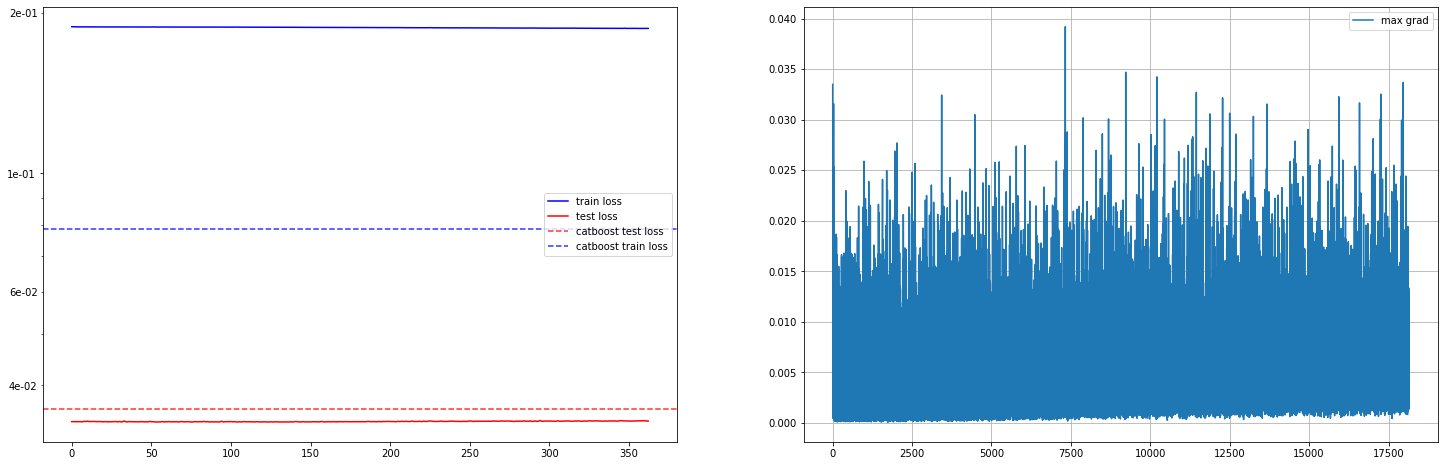

100%|██████████| 1815/1815 [20:28<00:00,  1.48it/s]


In [22]:
for epoch in range(10): # you may vary it, or think out of some stop criterion
    mmf_train_feature_set_t = torch.utils.data.DataLoader(mmf_train_feature_set,batch_size=mmf_params['batch_size'],shuffle=True,num_workers=0)
    try:
        with tqdm(mmf_train_feature_set_t) as progressbar:
            for mmf_episode in progressbar:
                predicted_return = mmf_lstm_model(mmf_episode[0])  # get mmf_lstm_model prediction calculated on the current episode features
                #print(mmf_episode[0].shape, mmf_episode[1].shape, type(mmf_episode), predicted_return.shape)
                train_loss = mmf_loss_fn(input=predicted_return, target=mmf_episode[1]) # calculate loss between actual and predicted values. please ignore the starting warm-up window in loss calculation
                train_loss_history.append(train_loss.item()) # store the loss of the current episode
                mmf_optimizer.zero_grad() # set the gradients of all optimized tensors to zero
                train_loss.backward() # backward propagation
                mmf_optimizer.step() # take an optimization step

                # it is in general a good idea to monitor max gradient and to be able to clip if necessary it using:
                # nn.utils.clip_grad_value_(mmf_lstm_model.parameters(), clip_value=1.0)
                max_gradient_history.append( np.max([torch.max(p.grad).item() for p in mmf_lstm_model.parameters() if p.grad is not None]) )

                if len(train_loss_history) % 50 == 0:
                    mmf_lstm_model.train(False) # disable learning mode

                    mse_train_history.append( mmf_loss_fn(mmf_activation_fn(mmf_lstm_model(X_train_t)),y_train_t).item() ) # losses calculcated on the whole history /
                    mse_test_history.append( mmf_loss_fn(mmf_activation_fn(mmf_lstm_model(X_test_t)),y_test_t).item() )    # unlike row #8 where the current episode only

                    mmf_lstm_model.train(True) # enable learning mode

                    clear_output(True)

                    fgs,axs = plt.subplots(1,2, figsize=[25,8])

                    axs[1].plot(max_gradient_history, label='max grad')
                    axs[1].legend(loc='best')
                    axs[1].grid()

                    axs[0].plot(mse_train_history, label='train loss', color='blue')
                    axs[0].plot(mse_test_history, label='test loss', color='red')
                    axs[0].set_yscale('log')
                    axs[0].yaxis.set_major_formatter(plt.LogFormatter())
                    axs[0].yaxis.set_minor_formatter(plt.LogFormatter())
                    axs[0].axhline(y=cb_mse_error_test, color='red', linestyle='--', alpha=0.8, label='catboost test loss')
                    axs[0].axhline(y=cb_mse_error_train, color='blue', linestyle='--', alpha=0.8, label='catboost train loss')
                    axs[0].legend(loc='best')

                    plt.show()
    except KeyboardInterrupt:
        pass